In [1]:
!pip install pymystem3==0.1.10
#необходимо для лемматизации 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: pymystem3
    Found existing installation: pymystem3 0.2.0
    Uninstalling pymystem3-0.2.0:
      Successfully uninstalled pymystem3-0.2.0


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm.auto import tqdm, trange
from pymystem3 import Mystem
import nltk
from nltk.stem import *
from nltk.corpus import stopwords
from string import punctuation
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer 
stemmer = SnowballStemmer("russian") 
nltk.download('stopwords')
nltk.download('punkt')
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [3]:
#с гугл диска, чтобы не закачивать постоянно
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



---

### **Датасеты новостей для проведения исследования**

---


Для проведения исследования были предоставлены 4 датасета с корпусами неразмеченных новостных данных за 2 года, сформированные из открытых источников.

20171201.csv - 159,7 MB, 227 387 новостей

20170901.csv - 449,3 MB, 617 990 новостей

20170601.csv - 438,0 MB, 584 368 новостей

20170301.csv - 476,0 MB, 576 383 новости

In [4]:
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/20171201.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227387 entries, 0 to 227386
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   u_id         227387 non-null  int64 
 1   provider     227387 non-null  object
 2   date_time    227387 non-null  object
 3   title        227387 non-null  object
 4   description  217791 non-null  object
 5   link         227373 non-null  object
 6   pubdate      227387 non-null  object
 7   numfield     227387 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 13.9+ MB


In [6]:
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/20170901.csv')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617990 entries, 0 to 617989
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   u_id         617990 non-null  int64 
 1   provider     617990 non-null  object
 2   date_time    617990 non-null  object
 3   title        617990 non-null  object
 4   description  587840 non-null  object
 5   link         617907 non-null  object
 6   pubdate      617990 non-null  object
 7   numfield     617990 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 37.7+ MB


In [8]:
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/20170601.csv')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 584369 entries, 0 to 584368
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   u_id         584369 non-null  int64 
 1   provider     584369 non-null  object
 2   date_time    584369 non-null  object
 3   title        584369 non-null  object
 4   description  551672 non-null  object
 5   link         584301 non-null  object
 6   pubdate      584369 non-null  object
 7   numfield     584369 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 35.7+ MB


In [10]:
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/20170301.csv')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 576383 entries, 0 to 576382
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   u_id         576383 non-null  int64 
 1   provider     576383 non-null  object
 2   date_time    576383 non-null  object
 3   title        576383 non-null  object
 4   description  542805 non-null  object
 5   link         576292 non-null  object
 6   pubdate      576383 non-null  object
 7   numfield     576383 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 35.2+ MB



---

### **1. Изучение датасета новостей (20170301.csv - 476,0 MB, 576 383 новости)**

---


знакомство с данными, со структурой датасета, посмотрим пропуски

в поле описания имеется много пропусков, логично вставить краткое описание title

In [12]:
df.head()

,u_id,provider,date_time,title,description,link,pubdate,numfield
0,103451,washingtonpostcom_world[eng],2017-01-17 20:15:49,"""$10,000 stuffed in a diplomat-s car."" Moscow ...",Russia-s foreign minister said that United Sta...,https://www.washingtonpost.com/news/worldviews...,17.01.2017 20:15,3
1,211367,vsesmiru_business,2017-02-02 06:00:33,"""100 друзей"" Гродненского мясокомбината",Дизайнеры агентства Fabula Branding (Минск) пр...,http://www.vsesmi.ru/business/2017/02/02/321648/,02.02.2017 01:03,4
2,13559,mailru_common,2016-11-28 13:30:23,"""12-я партия - игра жизни не только Карякина, ...",<p>Победитель шахматной олимпиады 1998 гроссме...,https://sport.mail.ru/news/chess/27940207/,28.11.2016 13:22,4
3,17165,mailru_common,2016-11-28 21:15:25,"""37 мне только по паспорту"". Почему Лебедев не...","<p>Боксёры Денис Лебедев и Мурат Гассиев, встр...",https://sport.mail.ru/news/boxing/27946630/,28.11.2016 21:09,4
4,147533,mailru_polit,2017-01-24 10:15:32,"""5 канал"": Украина подала в ЕСПЧ пять исков пр...",<p>Речь идет о событиях в Крыму и Донбассе и н...,https://news.mail.ru/politics/28526323/,24.01.2017 10:04,4


In [13]:
df['description']=df['description'].fillna(df['title'])


In [14]:
df=df[df['link'].str.contains("business") | df['link'].str.contains("finance") | df['link'].str.contains("economy")]


In [15]:
def detect_ru(row):
  alphabet = {"а","б","в","г","д","е","ё","ж","з","и","й","к","л","м","н","о",
              "п","р","с","т","у","ф","х","ц","ч","ш","щ","ъ","ы","ь","э","ю","я"}

  text = row['description']
  return bool(alphabet.intersection(set(text.lower())))


In [16]:
df['Languagereveiw'] = df.apply(detect_ru, axis=1)

In [17]:
df=df[df['Languagereveiw']==True ].reset_index(drop=True)
df.head()

,u_id,provider,date_time,title,description,link,pubdate,numfield,Languagereveiw
0,211367,vsesmiru_business,2017-02-02 06:00:33,"""100 друзей"" Гродненского мясокомбината",Дизайнеры агентства Fabula Branding (Минск) пр...,http://www.vsesmi.ru/business/2017/02/02/321648/,02.02.2017 01:03,4,True
1,353361,vsesmiru_business,2017-02-24 09:00:34,"""ArcelorMittal Кривой Рог"" инициировал антидем...","В течение 30 дней, с даты публикации сообщения...",http://www.vsesmi.ru/business/2017/02/24/385699/,24.02.2017 08:31,4,True
2,65369,newrucom_common,2016-12-05 20:30:06,"""Абсолютно никчемный аргумент"": Путин прокомме...",Глава государства назвал совершенно не имеющей...,http://www.newsru.com/finance/05dec2016/gazpro...,05.12.2016 20:26,4,True
3,58879,vsesmiru_business,2017-01-11 07:45:35,"""Аврора"" со следующей недели открывает новый р...","Интерфакс-Россия, Новость:\nАвиакомпания ""Авро...",http://www.vsesmi.ru/business/2017/01/11/256028/,11.01.2017 07:26,4,True
4,243101,vestifinance_common,2017-02-07 11:15:54,"""АвтоВАЗ"" наращивает продажи. Главное",Отечественный концерн по производству автомоби...,http://www.vestifinance.ru/videos/32121,07.02.2017 11:11,4,True


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37243 entries, 0 to 37242
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   u_id            37243 non-null  int64 
 1   provider        37243 non-null  object
 2   date_time       37243 non-null  object
 3   title           37243 non-null  object
 4   description     37243 non-null  object
 5   link            37243 non-null  object
 6   pubdate         37243 non-null  object
 7   numfield        37243 non-null  int64 
 8   Languagereveiw  37243 non-null  bool  
dtypes: bool(1), int64(2), object(6)
memory usage: 2.3+ MB


In [19]:
df.duplicated().sum()

0

In [20]:
#df=df[:2150]

In [21]:
dout=df['description']

In [22]:
dout.duplicated().sum()

1722

In [23]:
dout = dout.drop_duplicates()

In [24]:
dout.describe()

count                                                 35521
unique                                                35521
top       Дизайнеры агентства Fabula Branding (Минск) пр...
freq                                                      1
Name: description, dtype: object

In [25]:
dout.to_csv("descr.csv", index=False)

In [26]:
dout.head(15)

0     Дизайнеры агентства Fabula Branding (Минск) пр...
1     В течение 30 дней, с даты публикации сообщения...
2     Глава государства назвал совершенно не имеющей...
3     Интерфакс-Россия, Новость:\nАвиакомпания "Авро...
4     Отечественный концерн по производству автомоби...
5     "АвтоВАЗ" начал продажи автомобилей Lada Vesta...
6     Совет директоров "АвтоВАЗа" принял стратегичес...
7     "АвтоВАЗ" завершил размещение дополнительных а...
8     "АвтоВАЗ" в январе увеличил продажи на 4,6% в ...
9     "АвтоВАЗ" сократит 740 человек (2% сотрудников...
10    Картер Пейдж - человек, которого называют бывш...
11    Группа компаний «Агро-Белогорье» запустила тре...
12    "Ак Барс": Вопрос объединения с Татфондбанком ...
13    О перспективах деятельности, дивидендной полит...
14    В январе 2017 года ОАО «Алтайский маслосырзаво...
Name: description, dtype: object

In [27]:
from google.colab import files
files.download("descr.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Взяты только новости на русском языке. Разметка 2069 новостей**



---


### **2. Подготовка обучающего датасета**

---



In [28]:
df_train=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/descr_labeled.csv',sep='I',error_bad_lines=False)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [29]:
df_train.head(20)

,description,label
0,Дизайнеры агентства Fabula Branding (Минск) пр...,1
1,"В течение 30 дней, с даты публикации сообщения...",2
2,Глава государства назвал совершенно не имеющей...,2
3,"Интерфакс-Россия, Новость: Авиакомпания ""Аврор...",3
4,Отечественный концерн по производству автомоби...,4
5,"""АвтоВАЗ"" начал продажи автомобилей Lada Vesta...",3
6,"Совет директоров ""АвтоВАЗа"" принял стратегичес...",4
7,"""АвтоВАЗ"" завершил размещение дополнительных а...",3
8,"""АвтоВАЗ"" в январе увеличил продажи на 4,6% в ...",4
9,"""АвтоВАЗ"" сократит 740 человек (2% сотрудников...",5


In [30]:
df_train.tail(10)

,description,label
2059,"Шведский концерн IKEA, которому принадлежит кр...",3
2060,Шведская компания IKEA выплатит $50 млн в каче...,2
2061,"Компания IRI Investments Lietuva, контролируем...",3
2062,Краснинский суд Смоленской области арестовал с...,2
2063,Шведская компания IKEA не согласна с решением ...,2
2064,Шведская IKEA не будет строить торговый центр ...,3
2065,Шведская IKEA планирует выставить права на дол...,3
2066,Шведская компания IKEA намерена трудоустроить ...,3
2067,Шведский ритейлер IKEA направил обращение упол...,2
2068,Каждый пятый товар сети подешевеет на 15–20%,5


новости размечены вручную в программе CSVpad  

Разметка новостей:

Цель – определение оттенка новости для последующего прогнозирования их разделения

Метки ставятся следующим образом:  

1 - реклама, позитивное ожидание чего-либо 

2 - судебные дела, иски, претензии. Стоп-фактор, требует рассмотрения вручную.

3 - информационное сообщение, нейтральное по смыслу 

4 - рост продаж, производства, поставок - позитивный характер по сутевой составляющей 

5 - уменьшение чего - либо, продаж, поставок и т.д.  - негативный характер

**Пример разметки классов 1 и 2:**

**Класс 1** -  Дизайнеры агентства Fabula Branding (Минск) провели комплексную разработку торговой марки колбасных изделий «100 друзей» (нейминг, логотип, дизайн упаковки) для ОАО «Гродненский мясокомбинат». Продукт – колбасные изделия среднего ценового сегмента: сырокопченые, сыровяленые, вареные колбасы, сосиски и сардельки. Регионы продаж – Беларусь и Россия. Ситуации потребления: дружеские и семейные застолья, пикник, гости, быстрый перекус. Целевая аудитория – мужчины и женщины 25-40 лет. Решением стал теплый и яркий желтый цвет, который хорошо отстраивает продукт на полке, служит цветовым идентификатором торговой марки и вызывает приятные ассоциации с пикником / дружескими посиделками на даче. Дружелюбную и приветливую стилистику дизайна поддерживает цифра «100», образованная колбасками (маркер категории), а также рукописный шрифт логотипа.

**Класс 2** - В течение 30 дней, с даты публикации сообщения в "Урядовом курьере", министерство будет проводить регистрацию заинтересованных в расследовании лиц и рассматривает требования относительно проведения слушаний. В течение 60 дней, МЭРТ рассматривает письменно изложенные комментарии и информацию относительно возбуждения расследования.

**Пример разметки классов 3, 4 и 5:**

**Класс 3** -  Глава государства назвал совершенно не имеющей под собой оснований "идейкой" расхожее мнение о том, что те, кто покупает российский газ, попадают в зависимость от Москвы. "Это глупый абсолютно, никчемный аргумент, потому что это взаимозависимость", - подчеркнул президент России.

**Класс 4** -  "АвтоВАЗ" в январе увеличил продажи на 4,6% в годовом выражении до 16,3 тыс. автомобилей, сообщает компания. Доля Lada на российском рынке составила в прошлом месяце почти 19,5%, против 19,9% в 2016 г.

**Класс 5** - "АвтоВАЗ" сократит 740 человек (2% сотрудников). Попадающим под сокращение работникам предложены вакансии во всех подразделениях "АвтоВАЗа", в том числе в Индустриальном парке.

Было размечено вручную 2069 новостей, при этом класс проставлялся после изучения всего текста новости, при этом какой-то конкретный алгоритм выявления слов-маркеров отсутствовал.

In [31]:
df_train['label'].value_counts()

3    1125
1     464
2     213
4     155
5     112
Name: label, dtype: int64

теперь есть столбец текста новости и столбец метки новости



---


### 3. Очищение текста новости


---



удаляем стоп слова, обрабатываем текст

In [32]:
import string
def remove_punctuation(text):
    return "".join([ch if ch not in string.punctuation else ' ' for ch in text])

def remove_numbers(text):
    return ''.join([i if not i.isdigit() else ' ' for i in text])

import re
def remove_multiple_spaces(text):
	return re.sub(r'\s+', ' ', text, flags=re.I)


mystem = Mystem() 

russian_stopwords = stopwords.words("russian")
russian_stopwords.extend(['…', '«', '»', '...'])
def lemmatize_text(text):
    tokens = mystem.lemmatize(text.lower())
    tokens = [token for token in tokens if token not in russian_stopwords and token != " "]
    text = " ".join(tokens)
    return text

Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz


In [33]:
#df_train=df.reset_index(drop = True)

In [34]:
preproccessing = lambda text: (remove_multiple_spaces(remove_numbers(remove_punctuation(text))))
df_train['preproccessed'] = list(map(preproccessing, df_train['description']))

текст очищен от пунктуации, от пробелов, от цифр, и переведен в нижний регистр

In [35]:
prep_text = [remove_multiple_spaces(remove_numbers(remove_punctuation(text.lower()))) for text in tqdm(df_train['description'])]

  0%|          | 0/2069 [00:00<?, ?it/s]

In [36]:
len(prep_text)
prep_text[0]

'дизайнеры агентства fabula branding минск провели комплексную разработку торговой марки колбасных изделий « друзей» нейминг логотип дизайн упаковки для оао «гродненский мясокомбинат» продукт – колбасные изделия среднего ценового сегмента сырокопченые сыровяленые вареные колбасы сосиски и сардельки регионы продаж – беларусь и россия ситуации потребления дружеские и семейные застолья пикник гости быстрый перекус целевая аудитория – мужчины и женщины лет решением стал теплый и яркий желтый цвет который хорошо отстраивает продукт на полке служит цветовым идентификатором торговой марки и вызывает приятные ассоциации с пикником дружескими посиделками на даче дружелюбную и приветливую стилистику дизайна поддерживает цифра « » образованная колбасками маркер категории а также рукописный шрифт логотипа '

In [37]:
df_train['text_prep'] = prep_text

In [38]:
df_train.head()

,description,label,preproccessed,text_prep
0,Дизайнеры агентства Fabula Branding (Минск) пр...,1,Дизайнеры агентства Fabula Branding Минск пров...,дизайнеры агентства fabula branding минск пров...
1,"В течение 30 дней, с даты публикации сообщения...",2,В течение дней с даты публикации сообщения в У...,в течение дней с даты публикации сообщения в у...
2,Глава государства назвал совершенно не имеющей...,2,Глава государства назвал совершенно не имеющей...,глава государства назвал совершенно не имеющей...
3,"Интерфакс-Россия, Новость: Авиакомпания ""Аврор...",3,Интерфакс Россия Новость Авиакомпания Аврора с...,интерфакс россия новость авиакомпания аврора с...
4,Отечественный концерн по производству автомоби...,4,Отечественный концерн по производству автомоби...,отечественный концерн по производству автомоби...




---


### 4. Стэмминг


---



In [39]:
russian_stopwords = stopwords.words("russian")
russian_stopwords.extend(['…', '«', '»', '...', 'т.д.', 'т', 'д'])

In [40]:
text = df_train['text_prep'][1]
word_tokenize(text) 

['в',
 'течение',
 'дней',
 'с',
 'даты',
 'публикации',
 'сообщения',
 'в',
 'урядовом',
 'курьере',
 'министерство',
 'будет',
 'проводить',
 'регистрацию',
 'заинтересованных',
 'в',
 'расследовании',
 'лиц',
 'и',
 'рассматривает',
 'требования',
 'относительно',
 'проведения',
 'слушаний',
 'в',
 'течение',
 'дней',
 'мэрт',
 'рассматривает',
 'письменно',
 'изложенные',
 'комментарии',
 'и',
 'информацию',
 'относительно',
 'возбуждения',
 'расследования']

In [41]:
stemmed_texts_list = []
for text in tqdm(df_train['text_prep']):
    tokens = word_tokenize(text)    
    stemmed_tokens = [stemmer.stem(token) for token in tokens if token not in russian_stopwords]
    text = " ".join(stemmed_tokens)
    stemmed_texts_list.append(text)

df_train['text_stem'] = stemmed_texts_list

  0%|          | 0/2069 [00:00<?, ?it/s]

In [42]:
def remove_stop_words(text):
    tokens = word_tokenize(text) 
    tokens = [token for token in tokens if token not in russian_stopwords and token != ' ']
    return " ".join(tokens)

In [43]:
sw_texts_list = []
for text in tqdm(df_train['text_prep']):
    tokens = word_tokenize(text)    
    tokens = [token for token in tokens if token not in russian_stopwords and token != ' ']
    text = " ".join(tokens)
    sw_texts_list.append(text)

df_train['text_sw'] = sw_texts_list

  0%|          | 0/2069 [00:00<?, ?it/s]

In [44]:
df_train.head()

,description,label,preproccessed,text_prep,text_stem,text_sw
0,Дизайнеры агентства Fabula Branding (Минск) пр...,1,Дизайнеры агентства Fabula Branding Минск пров...,дизайнеры агентства fabula branding минск пров...,дизайнер агентств fabula branding минск провел...,дизайнеры агентства fabula branding минск пров...
1,"В течение 30 дней, с даты публикации сообщения...",2,В течение дней с даты публикации сообщения в У...,в течение дней с даты публикации сообщения в у...,течен дне дат публикац сообщен урядов курьер м...,течение дней даты публикации сообщения урядово...
2,Глава государства назвал совершенно не имеющей...,2,Глава государства назвал совершенно не имеющей...,глава государства назвал совершенно не имеющей...,глав государств назва совершен имеющ соб основ...,глава государства назвал совершенно имеющей со...
3,"Интерфакс-Россия, Новость: Авиакомпания ""Аврор...",3,Интерфакс Россия Новость Авиакомпания Аврора с...,интерфакс россия новость авиакомпания аврора с...,интерфакс росс новост авиакомпан аврор январ г...,интерфакс россия новость авиакомпания аврора я...
4,Отечественный концерн по производству автомоби...,4,Отечественный концерн по производству автомоби...,отечественный концерн по производству автомоби...,отечествен концерн производств автомобил отчит...,отечественный концерн производству автомобилей...




---


### 5. Лемматизация


---



In [45]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2069 entries, 0 to 2068
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   description    2069 non-null   object
 1   label          2069 non-null   int64 
 2   preproccessed  2069 non-null   object
 3   text_prep      2069 non-null   object
 4   text_stem      2069 non-null   object
 5   text_sw        2069 non-null   object
dtypes: int64(1), object(5)
memory usage: 97.1+ KB


In [46]:
lemm_texts_list = []
for text in tqdm(df_train['text_sw']):
    #print(text)
    try:
        text_lem = mystem.lemmatize(text)
        tokens = [token for token in text_lem if token != ' ' and token not in russian_stopwords]
        text = " ".join(tokens)
        lemm_texts_list.append(text)
    except Exception as e:
        print(e)
    
df_train['text_lemm'] = lemm_texts_list

  0%|          | 0/2069 [00:00<?, ?it/s]

In [47]:
df_train.tail(20)

,description,label,preproccessed,text_prep,text_stem,text_sw,text_lemm
2049,От Ассоциации предприятий информационных техно...,3,От Ассоциации предприятий информационных техно...,от ассоциации предприятий информационных техно...,ассоциац предприят информацион технолог украин...,ассоциации предприятий информационных технолог...,ассоциация предприятие информационный технолог...
2050,IBU временно отстранил от соревнований российс...,2,IBU временно отстранил от соревнований российс...,ibu временно отстранил от соревнований российс...,ibu времен отстран соревнован российск биатлон...,ibu временно отстранил соревнований российскую...,ibu временно отстранять соревнование российски...
2051,АйСиБиСи Банк (100% &amp;quot;дочка&amp;quot; ...,3,АйСиБиСи Банк amp quot дочка amp quot крупнейш...,айсибиси банк amp quot дочка amp quot крупнейш...,айсибис банк amp quot дочк amp quot крупн банк...,айсибиси банк amp quot дочка amp quot крупнейш...,айсибиси банк amp quot дочка amp quot крупный ...
2052,В феврале 2017 года состоится первая встреча с...,3,В феврале года состоится первая встреча с поте...,в феврале года состоится первая встреча с поте...,феврал год состо перв встреч потенциальн инвес...,феврале года состоится первая встреча потенциа...,февраль год состояться первый встреча потенциа...
2053,Исламская корпорация по развитию частного сект...,3,Исламская корпорация по развитию частного сект...,исламская корпорация по развитию частного сект...,исламск корпорац развит частн сектор,исламская корпорация развитию частного сектора,исламский корпорация развитие частный сектор \n
2054,Россия и Объединенные Арабские Эмираты договор...,1,Россия и Объединенные Арабские Эмираты договор...,россия и объединенные арабские эмираты договор...,росс объединен арабск эмират договор развива с...,россия объединенные арабские эмираты договорил...,россия объединять арабский эмират договаривать...
2055,Каир продолжает рассматривать российское предл...,3,Каир продолжает рассматривать российское предл...,каир продолжает рассматривать российское предл...,каир продолжа рассматрива российск предложен к...,каир продолжает рассматривать российское предл...,каир продолжать рассматривать российский предл...
2056,"IKEA Group, являющаяся оператором большинства ...",3,IKEA Group являющаяся оператором большинства м...,ikea group являющаяся оператором большинства м...,ikea group явля оператор большинств магазин ik...,ikea group являющаяся оператором большинства м...,ikea group являться оператор большинство магаз...
2057,Каждый сотрудник шведской корпорации IKEA в Ве...,1,Каждый сотрудник шведской корпорации IKEA в Ве...,каждый сотрудник шведской корпорации ikea в ве...,кажд сотрудник шведск корпорац ikea великобрит...,каждый сотрудник шведской корпорации ikea вели...,каждый сотрудник шведский корпорация ikea вели...
2058,Каждый сотрудник шведской корпорации IKEA в Ве...,1,Каждый сотрудник шведской корпорации IKEA в Ве...,каждый сотрудник шведской корпорации ikea в ве...,кажд сотрудник шведск корпорац ikea великобрит...,каждый сотрудник шведской корпорации ikea вели...,каждый сотрудник шведский корпорация ikea вели...


In [48]:
df_train.to_csv('df_train_prep.csv', index=False)

In [49]:
from google.colab import files
files.download("df_train_prep.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [50]:
X = df_train['text_sw']
y = df_train['label']

разобьем обучающий датасет на train и test

In [51]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

In [52]:
my_tags = df_train['label'].unique().astype('str')
my_tags

array(['1', '2', '3', '4', '5'], dtype='<U21')

In [53]:
X[0]

'дизайнеры агентства fabula branding минск провели комплексную разработку торговой марки колбасных изделий друзей нейминг логотип дизайн упаковки оао гродненский мясокомбинат продукт – колбасные изделия среднего ценового сегмента сырокопченые сыровяленые вареные колбасы сосиски сардельки регионы продаж – беларусь россия ситуации потребления дружеские семейные застолья пикник гости быстрый перекус целевая аудитория – мужчины женщины лет решением стал теплый яркий желтый цвет который отстраивает продукт полке служит цветовым идентификатором торговой марки вызывает приятные ассоциации пикником дружескими посиделками даче дружелюбную приветливую стилистику дизайна поддерживает цифра образованная колбасками маркер категории также рукописный шрифт логотипа'

In [ ]:
y[0]

1


---


### 6. Байесовский классификатор


---


In [54]:
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])

In [55]:
%%time
nb.fit(X_train, y_train)

CPU times: user 46.3 ms, sys: 36 µs, total: 46.3 ms
Wall time: 55.2 ms


Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

In [56]:
%%time
from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

CPU times: user 14.2 ms, sys: 22 µs, total: 14.2 ms
Wall time: 14.8 ms


In [57]:
y_pred[0]

3

In [58]:
my_tags = df_train['label'].unique().astype('str')
my_tags

array(['1', '2', '3', '4', '5'], dtype='<U21')

In [59]:

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred, target_names=my_tags))

accuracy 0.5684380032206119
              precision    recall  f1-score   support

           1       0.88      0.10      0.19       143
           2       1.00      0.03      0.06        68
           3       0.56      1.00      0.72       335
           4       0.33      0.03      0.05        38
           5       0.00      0.00      0.00        37

    accuracy                           0.57       621
   macro avg       0.55      0.23      0.20       621
weighted avg       0.63      0.57      0.44       621



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




---


### Linear Support Vector Machine


---



In [60]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('sgd', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])

In [61]:
%%time
sgd.fit(X_train, y_train)

CPU times: user 57.7 ms, sys: 6.86 ms, total: 64.6 ms
Wall time: 58.7 ms


Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('sgd',
                 SGDClassifier(alpha=0.001, max_iter=5, random_state=42,
                               tol=None))])

In [62]:
%%time
y_pred = sgd.predict(X_test)

CPU times: user 14.6 ms, sys: 952 µs, total: 15.5 ms
Wall time: 15.8 ms


In [63]:
print('Итоги тестирования обученной модели LSVM')
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

Итоги тестирования обученной модели LSVM
accuracy 0.6280193236714976
              precision    recall  f1-score   support

           1       0.59      0.22      0.32       143
           2       0.84      0.38      0.53        68
           3       0.63      0.96      0.76       335
           4       0.38      0.24      0.29        38
           5       0.60      0.08      0.14        37

    accuracy                           0.63       621
   macro avg       0.61      0.38      0.41       621
weighted avg       0.63      0.63      0.57       621



### Случайный лес

In [64]:
from sklearn.ensemble import RandomForestClassifier

rf_model = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('rf', RandomForestClassifier()),
               ])

In [65]:
%%time
rf_model.fit(X_train, y_train)

CPU times: user 823 ms, sys: 15.1 ms, total: 838 ms
Wall time: 838 ms


Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('rf', RandomForestClassifier())])

In [66]:
%%time
y_pred = rf_model.predict(X_test)

CPU times: user 55.3 ms, sys: 0 ns, total: 55.3 ms
Wall time: 57.4 ms


In [67]:
print('Итоги тестирования обученной модели случайного леса')
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

Итоги тестирования обученной модели случайного леса
accuracy 0.6264090177133655
              precision    recall  f1-score   support

           1       0.63      0.23      0.34       143
           2       0.84      0.38      0.53        68
           3       0.61      0.94      0.74       335
           4       0.67      0.26      0.38        38
           5       0.83      0.14      0.23        37

    accuracy                           0.63       621
   macro avg       0.72      0.39      0.44       621
weighted avg       0.66      0.63      0.57       621



### Logistic Regression

In [68]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('logreg', LogisticRegression(n_jobs=1, C=1e5)),
               ])

In [69]:
%%time
logreg.fit(X_train, y_train)

CPU times: user 928 ms, sys: 577 ms, total: 1.5 s
Wall time: 866 ms


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('logreg', LogisticRegression(C=100000.0, n_jobs=1))])

In [70]:
%%time
y_pred = logreg.predict(X_test)

CPU times: user 16.5 ms, sys: 0 ns, total: 16.5 ms
Wall time: 16.6 ms


In [71]:
print('Итоги тестирования обученной модели логистической регрессией')
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

Итоги тестирования обученной модели логистической регрессией
accuracy 0.642512077294686
              precision    recall  f1-score   support

           1       0.55      0.36      0.43       143
           2       0.79      0.46      0.58        68
           3       0.67      0.87      0.76       335
           4       0.42      0.50      0.46        38
           5       0.67      0.16      0.26        37

    accuracy                           0.64       621
   macro avg       0.62      0.47      0.50       621
weighted avg       0.64      0.64      0.62       621



In [72]:
X_train[0]

'дизайнеры агентства fabula branding минск провели комплексную разработку торговой марки колбасных изделий друзей нейминг логотип дизайн упаковки оао гродненский мясокомбинат продукт – колбасные изделия среднего ценового сегмента сырокопченые сыровяленые вареные колбасы сосиски сардельки регионы продаж – беларусь россия ситуации потребления дружеские семейные застолья пикник гости быстрый перекус целевая аудитория – мужчины женщины лет решением стал теплый яркий желтый цвет который отстраивает продукт полке служит цветовым идентификатором торговой марки вызывает приятные ассоциации пикником дружескими посиделками даче дружелюбную приветливую стилистику дизайна поддерживает цифра образованная колбасками маркер категории также рукописный шрифт логотипа'

In [73]:
y_pred[0]

3

In [74]:
travel_text = '''отечественный концерн производству автомобилей отчитался росте продаж январе показатель увеличился тысяч единиц прогнозам компании lada vesta выйти третье место объему продаж россии'''

In [75]:
grow_up = remove_multiple_spaces(remove_numbers(remove_punctuation(travel_text.lower())))
grow_up = remove_stop_words(travel_text)

In [76]:
pred = logreg.predict([grow_up])
pred

array([4])

Категория 4 новости об увеличении экономических показателей - была предсказана верно

In [77]:
sud_text='течение дней даты публикации сообщения урядовом курьере министерство проводить регистрацию заинтересованных расследовании лиц рассматривает требования относительно проведения слушаний течение дней мэрт рассматривает письменно изложенные комментарии информацию относительно возбуждения расследования'

In [78]:
sud = remove_multiple_spaces(remove_numbers(remove_punctuation(sud_text.lower())))
sud = remove_stop_words(travel_text)

In [79]:
pred = logreg.predict([sud])
pred

array([4])

### Кластеризация

In [80]:
texts = df_train['description']
type(texts)

pandas.core.series.Series

In [81]:
def token_and_stem(text):
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[а-яА-Я]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

In [82]:
stopwords = nltk.corpus.stopwords.words('russian')
#можно расширить список стоп-слов
stopwords.extend(['что', 'это', 'так', 'вот', 'быть', 'как', 'в', 'к', 'на'])

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

n_featur=200000
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000,
                                 min_df=0.01, stop_words=stopwords,
                                 use_idf=True, tokenizer=token_and_stem, ngram_range=(1,3))

In [83]:
%%time
tfidf_matrix = tfidf_vectorizer.fit_transform(texts)


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['бол', 'больш', 'будт', 'быт', 'вед', 'впроч', 'всег', 'всегд', 'даж', 'друг', 'е', 'ег', 'ем', 'есл', 'ест', 'ещ', 'зач', 'зде', 'ил', 'иногд', 'когд', 'конечн', 'куд', 'лучш', 'межд', 'мен', 'мног', 'мо', 'можн', 'нег', 'нельз', 'нибуд', 'никогд', 'нич', 'опя', 'посл', 'пот', 'почт', 'разв', 'сво', 'себ', 'совс', 'теб', 'тепер', 'тог', 'тогд', 'тож', 'тольк', 'хорош', 'хот', 'чег', 'чут', 'эт'] not in stop_words.
  % sorted(inconsistent)


CPU times: user 3.24 s, sys: 29.9 ms, total: 3.27 s
Wall time: 3.28 s


In [84]:
type(tfidf_matrix)
tfidf_matrix

<2069x462 sparse matrix of type '<class 'numpy.float64'>'
	with 22658 stored elements in Compressed Sparse Row format>

In [85]:
num_clusters = 5

# Метод к-средних - KMeans
from sklearn.cluster import KMeans
km = KMeans(n_clusters=num_clusters)

In [86]:
%%time
km.fit(tfidf_matrix)

CPU times: user 423 ms, sys: 7.11 ms, total: 430 ms
Wall time: 240 ms


KMeans(n_clusters=5)

In [87]:
%%time
idx = km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

CPU times: user 388 ms, sys: 4.93 ms, total: 393 ms
Wall time: 205 ms


In [88]:
len(km.labels_)
clusters[:10]

[0, 0, 1, 0, 0, 0, 0, 2, 0, 0]

In [89]:
clusterkm = km.labels_.tolist()
frame = pd.DataFrame(texts)

#k-means
out = { 'text': texts, 'cluster': clusterkm, 'topic': df_train['label'] }
frame1 = pd.DataFrame(out, columns = ['text', 'cluster', 'topic'])

In [90]:
frame1.head(10)

,text,cluster,topic
0,Дизайнеры агентства Fabula Branding (Минск) пр...,0,1
1,"В течение 30 дней, с даты публикации сообщения...",0,2
2,Глава государства назвал совершенно не имеющей...,1,2
3,"Интерфакс-Россия, Новость: Авиакомпания ""Аврор...",0,3
4,Отечественный концерн по производству автомоби...,0,4
5,"""АвтоВАЗ"" начал продажи автомобилей Lada Vesta...",0,3
6,"Совет директоров ""АвтоВАЗа"" принял стратегичес...",0,4
7,"""АвтоВАЗ"" завершил размещение дополнительных а...",2,3
8,"""АвтоВАЗ"" в январе увеличил продажи на 4,6% в ...",0,4
9,"""АвтоВАЗ"" сократит 740 человек (2% сотрудников...",0,5


In [91]:
frame1.tail(10)

,text,cluster,topic
2059,"Шведский концерн IKEA, которому принадлежит кр...",0,3
2060,Шведская компания IKEA выплатит $50 млн в каче...,1,2
2061,"Компания IRI Investments Lietuva, контролируем...",2,3
2062,Краснинский суд Смоленской области арестовал с...,0,2
2063,Шведская компания IKEA не согласна с решением ...,1,2
2064,Шведская IKEA не будет строить торговый центр ...,0,3
2065,Шведская IKEA планирует выставить права на дол...,0,3
2066,Шведская компания IKEA намерена трудоустроить ...,0,3
2067,Шведский ритейлер IKEA направил обращение упол...,0,2
2068,Каждый пятый товар сети подешевеет на 15–20%,0,5


In [92]:
frame1.describe()

,cluster,topic
count,2069.000000,2069.000000
mean,0.739004,2.631706
std,1.103683,1.075344
min,0.000000,1.000000
25%,0.000000,2.000000
50%,0.000000,3.000000
75%,1.000000,3.000000
max,4.000000,5.000000


## N-grams (bigrams, trigrams, fourgrams, fivegrams)

In [93]:
from __future__ import unicode_literals
import nltk
from nltk import word_tokenize
from nltk.util import ngrams
from collections import Counter

In [94]:
def main_words1(row):
      return nltk.word_tokenize(row['description'])# токинезация текста i-го документа 

In [95]:
words1=df_train.apply(main_words1,axis=1)
words1

0       [Дизайнеры, агентства, Fabula, Branding, (, Ми...
1       [В, течение, 30, дней, ,, с, даты, публикации,...
2       [Глава, государства, назвал, совершенно, не, и...
3       [Интерфакс-Россия, ,, Новость, :, Авиакомпания...
4       [Отечественный, концерн, по, производству, авт...
                              ...                        
2064    [Шведская, IKEA, не, будет, строить, торговый,...
2065    [Шведская, IKEA, планирует, выставить, права, ...
2066    [Шведская, компания, IKEA, намерена, трудоустр...
2067    [Шведский, ритейлер, IKEA, направил, обращение...
2068    [Каждый, пятый, товар, сети, подешевеет, на, 1...
Length: 2069, dtype: object

In [96]:
ww=[]
for i in range(len(words1)):
  if type(words1[i])==list:
     ww=ww+words1[i]
word = list(filter(lambda x: x  != 'quot', ww))
word_ws=[w.lower()  for w in   word if w.isalpha() ]#исключение слов и символов      
token=[w for w in word_ws if w not in russian_stopwords ]#нижний регистр 

bigrams = ngrams(token,2)
trigrams = ngrams(token,3)
fourgrams = ngrams(token,4)
fivegrams = ngrams(token,5)

In [97]:
Counter(bigrams).most_common(5)

[(('говорится', 'сообщении'), 62),
 (('уровне', 'баррель'), 62),
 (('млрд', 'рублей'), 61),
 (('deutsche', 'bank'), 48),
 (('млрд', 'руб'), 46)]

In [98]:
Counter(trigrams).most_common(5)

[(('фьючерсы', 'brent', 'торговались'), 35),
 (('сообщает', 'rns', 'ссылкой'), 25),
 (('бирже', 'ice', 'futures'), 24),
 (('сша', 'дональда', 'трампа'), 23),
 (('лондонской', 'бирже', 'ice'), 23)]

In [99]:
Counter(fourgrams).most_common(5)

[(('лондонской', 'бирже', 'ice', 'futures'), 23),
 (('президента', 'сша', 'дональда', 'трампа'), 22),
 (('фьючерсы', 'brent', 'торговались', 'лондоне'), 20),
 (('brent', 'торговались', 'лондоне', 'уровне'), 20),
 (('торговались', 'лондоне', 'уровне', 'баррель'), 20)]

In [100]:
Counter(fivegrams).most_common(5)

[(('фьючерсы', 'brent', 'торговались', 'лондоне', 'уровне'), 20),
 (('brent', 'торговались', 'лондоне', 'уровне', 'баррель'), 20),
 (('электронных', 'торгах', 'товарной', 'биржи', 'nymex'), 15),
 (('общий', 'объем', 'продажи', 'иностранной', 'валюты'), 14),
 (('объем', 'продажи', 'иностранной', 'валюты', 'долларовом'), 14)]

### BigARTM

In [101]:
text=df_train['description']
freq=nltk.FreqDist(text)

посмотрим наиболее часто встречающиеся слова, возможно, отсюда уже можно будет ориентироваться на категории новостей

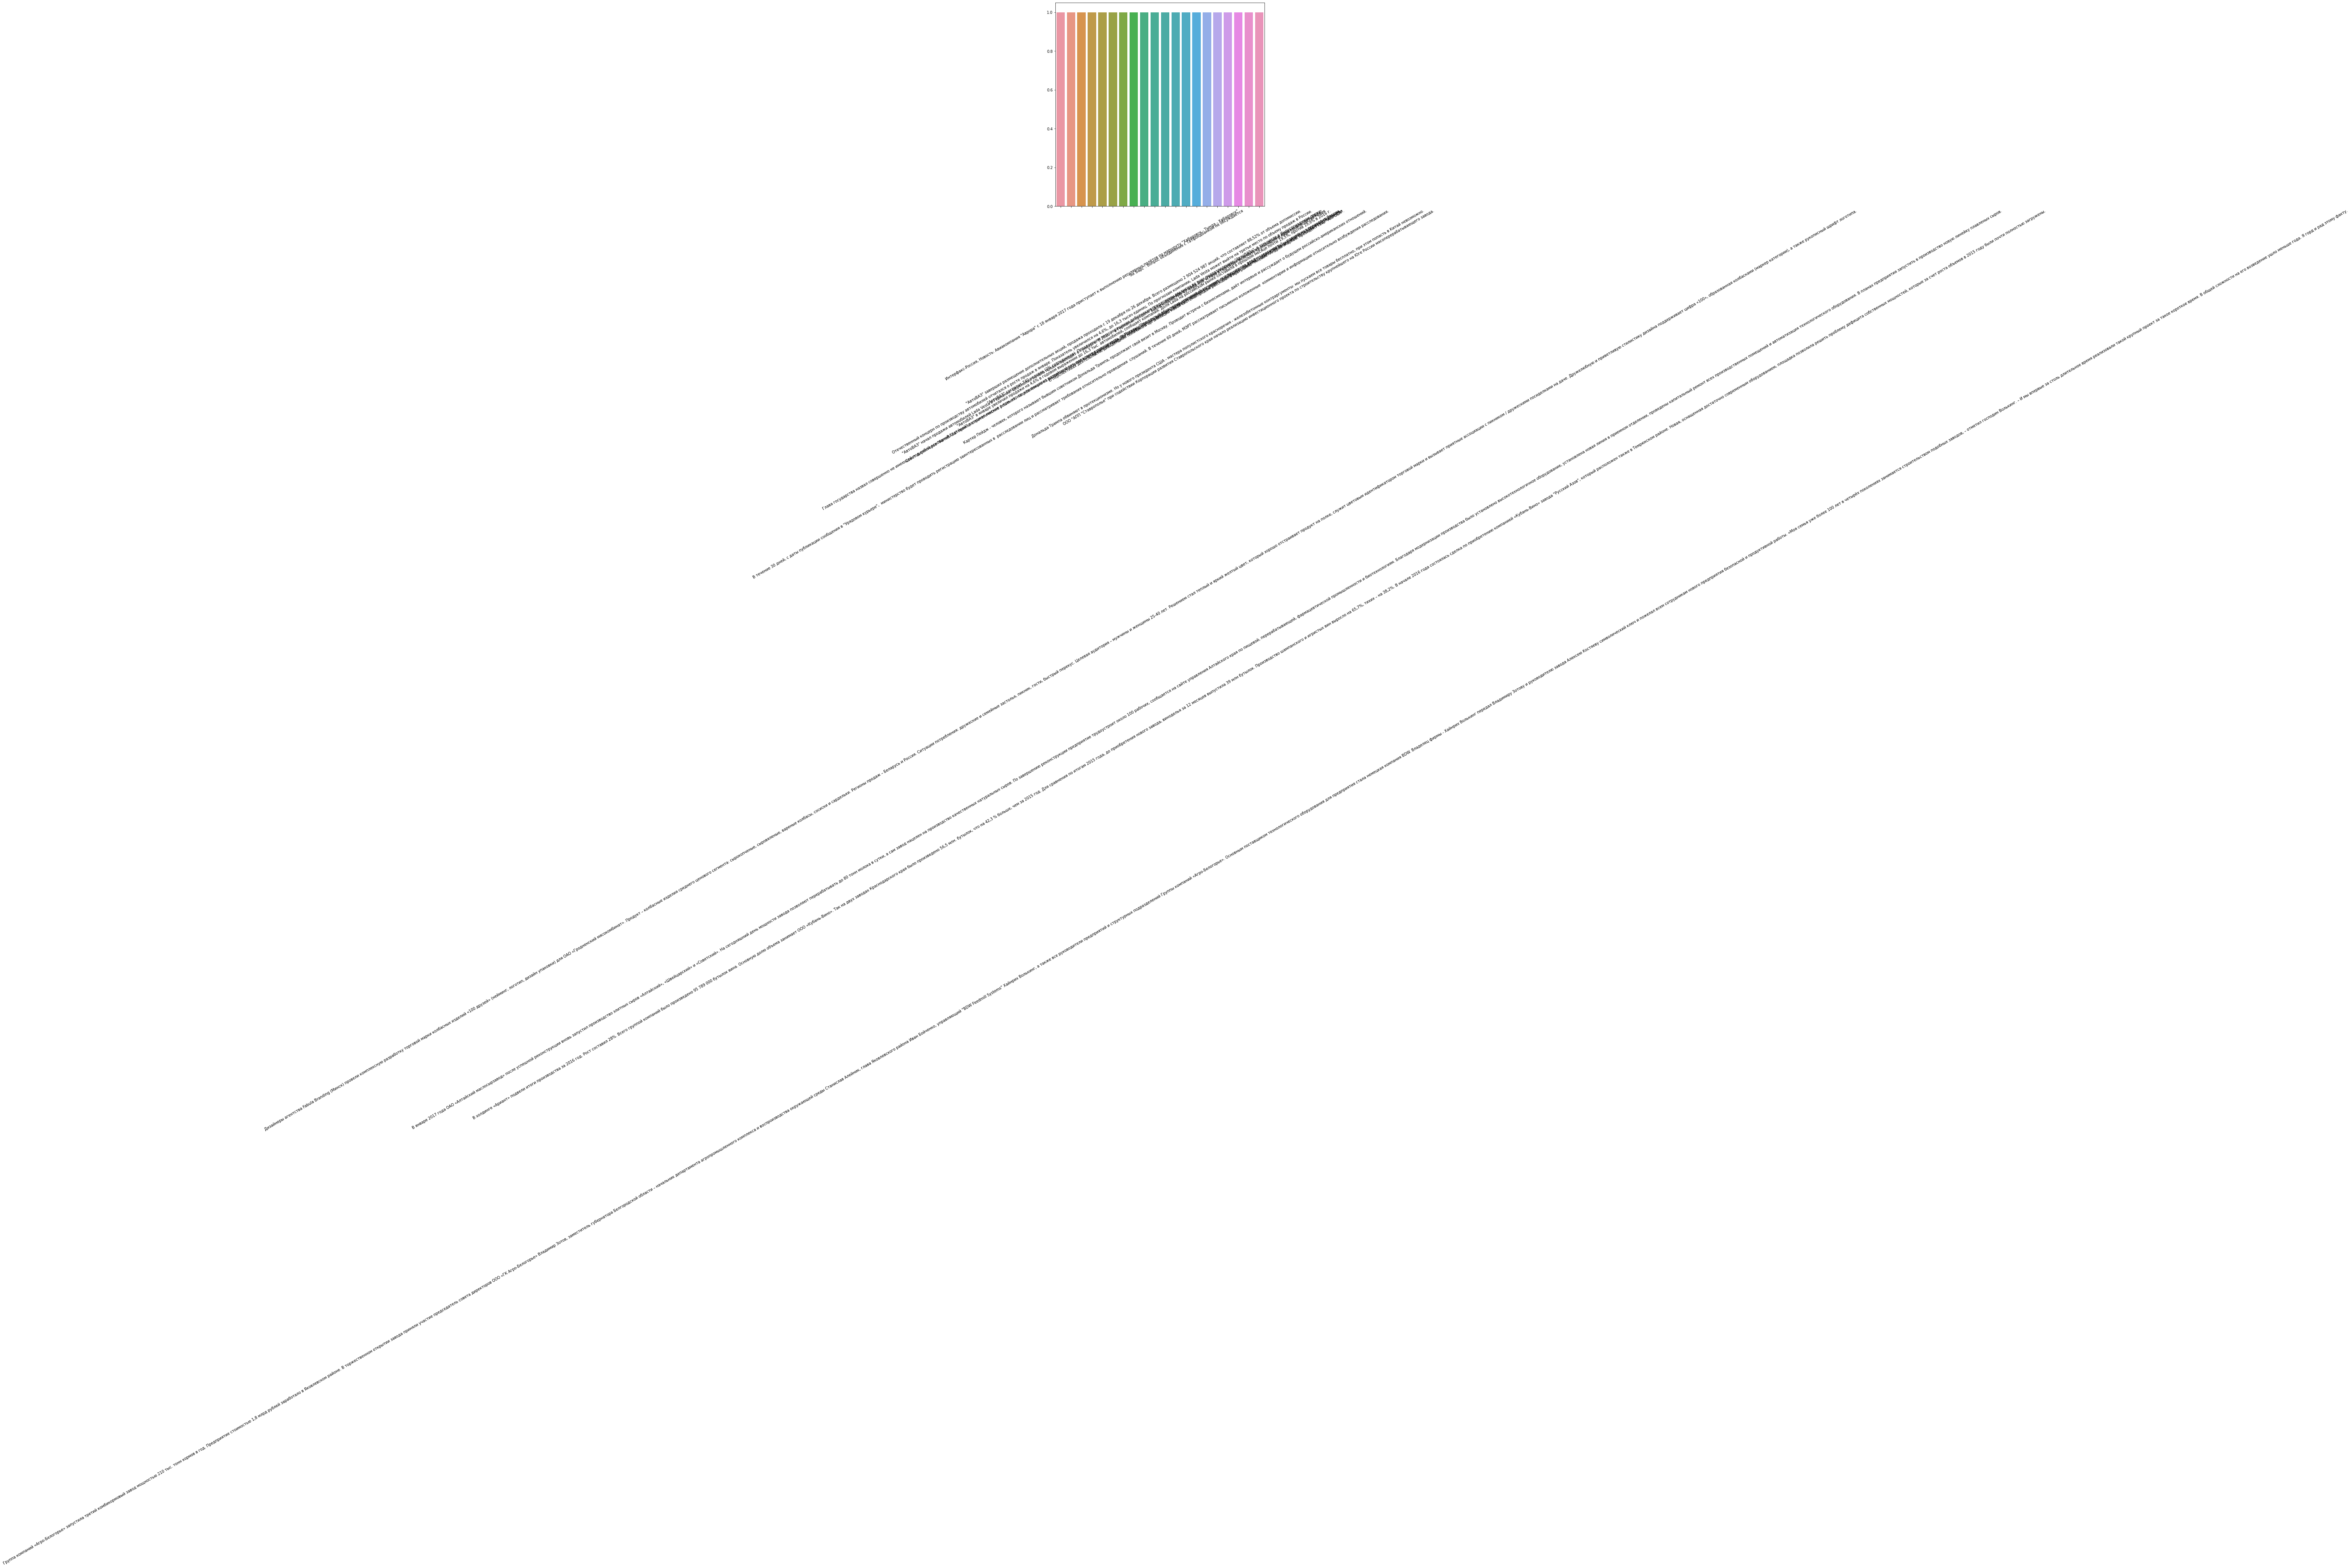

In [102]:
## Creating FreqDist for whole BoW, keeping the 20 most common tokens
all_fdist = freq.most_common(20)

## Conversion to Pandas series via Python Dictionary for easier plotting
all_fdist = pd.Series(dict(all_fdist))

## Setting figure, ax into variables
fig, ax = plt.subplots(figsize=(10,10))

## Seaborn plotting using Pandas attributes + xtick rotation for ease of viewing
all_plot = sns.barplot(x=all_fdist.index, y=all_fdist.values, ax=ax)
plt.xticks(rotation=30);

нет, это все общеупотребительные слова

In [103]:
text

0       Дизайнеры агентства Fabula Branding (Минск) пр...
1       В течение 30 дней, с даты публикации сообщения...
2       Глава государства назвал совершенно не имеющей...
3       Интерфакс-Россия, Новость: Авиакомпания "Аврор...
4       Отечественный концерн по производству автомоби...
                              ...                        
2064    Шведская IKEA не будет строить торговый центр ...
2065    Шведская IKEA планирует выставить права на дол...
2066    Шведская компания IKEA намерена трудоустроить ...
2067    Шведский ритейлер IKEA направил обращение упол...
2068         Каждый пятый товар сети подешевеет на 15–20%
Name: description, Length: 2069, dtype: object

In [104]:
def main_words1(row):
      return nltk.word_tokenize(row['description'])# токинезация текста i-го документа 

In [105]:
words1=df_train.apply(main_words1,axis=1)

In [106]:
words1

0       [Дизайнеры, агентства, Fabula, Branding, (, Ми...
1       [В, течение, 30, дней, ,, с, даты, публикации,...
2       [Глава, государства, назвал, совершенно, не, и...
3       [Интерфакс-Россия, ,, Новость, :, Авиакомпания...
4       [Отечественный, концерн, по, производству, авт...
                              ...                        
2064    [Шведская, IKEA, не, будет, строить, торговый,...
2065    [Шведская, IKEA, планирует, выставить, права, ...
2066    [Шведская, компания, IKEA, намерена, трудоустр...
2067    [Шведский, ритейлер, IKEA, направил, обращение...
2068    [Каждый, пятый, товар, сети, подешевеет, на, 1...
Length: 2069, dtype: object

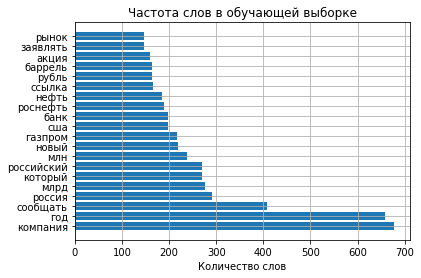

In [107]:
count=0
ww=[]
for i in range(len(words1)):
  if type(words1[i])==list:
     ww=ww+words1[i]
     count+=1
word = list(filter(lambda x: x  != 'quot', ww))
word_ws=[w.lower()  for w in   word if w.isalpha() ]#исключение слов и символов      
word_w=[w for w in word_ws if w not in russian_stopwords ]#нижний регистр 
lem = mystem.lemmatize ((" ").join(word_w))# лемматизация i -го документа
lem=[w for w in lem if w.isalpha() and len(w)>1] 
freq=nltk.FreqDist(lem)# распределение слов в i -м документе по частоте
z=[]# обновление списка для нового документа
z=[(key+":"+str(val)) for key,val in freq.items() if val>1] # частота упоминания через : от слова 

    #text=text+"|text" +" "+str((" ").join(z))+'\n'# запись в мешок слов с меткой |text     
    #text=text+"|text" +" "+str((" ").join(z).encode('utf-8'))+'\n'# запись в мешок слов с меткой |text          
c=[];d=[]
for key,val in freq.items():#подготовка к сортировке слов по убыванию частоты в i -м документе
        if val>1:
            c.append(val); d.append(key)
a=[];b=[]    
for k in np.arange(0,len(c),1):#сортировка слов по убыванию частоты в i -м документе 
                ind=c.index(max(c));  a.append(c[ind])
                b.append(d[ind]); del c[ind]; del d[ind]

a=a[0:20];b=b[0:20]# TOP-10 для частот a  и слов b в i -м документе    
y_pos = np.arange(1,len(a)+1,1)#построение TOP-10 диаграмм      
performance =a
plt.barh(y_pos, a)
plt.yticks(y_pos, b)
plt.xlabel(u'Количество слов')
plt.title(u'Частота слов в обучающей выборке', size=12)
plt.grid(True)
plt.show()  




In [108]:
sw_texts_list = []
for text in tqdm(df_train['text_prep']):
    tokens = word_tokenize(text)    
    tokens = [token for token in tokens if token not in russian_stopwords and token != ' ']
    text = " ".join(tokens)
    sw_texts_list.append(text)

df_train['text_sw'] = sw_texts_list

  0%|          | 0/2069 [00:00<?, ?it/s]

In [109]:
count

2069

In [110]:
#здесь теперь word содержит все слова с обучающей выборки
#далее это пригодится для bigARTM
len(word)

79180

In [111]:
!pip install bigartm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 26.5 MB/s 


In [112]:
import artm


from sklearn.feature_extraction.text import CountVectorizer

from numpy import array

cv = CountVectorizer(max_features=1000, stop_words='english')
n_wd = array(cv.fit_transform(word).todense()).T
vocabulary = cv.get_feature_names_out()

bv = artm.BatchVectorizer(data_format='bow_n_wd',
                          n_wd=n_wd,
                          vocabulary=vocabulary)

In [113]:
lda = artm.LDA(num_topics=5, alpha=0.01, beta=0.001,
               num_document_passes=5, dictionary=bv.dictionary,
               cache_theta=True)

In [114]:
lda.fit_offline(batch_vectorizer=bv, num_collection_passes=10)

In [115]:
top_tokens = lda.get_top_tokens(num_tokens=10)
for i, token_list in enumerate(top_tokens):
    print ('Topic #{0}: {1}'.format(i, token_list))

Topic #0: ['на', 'по', 'года', 'млрд', 'ссылкой', 'будет', 'заявил', 'передает', 'может', 'это']
Topic #1: ['компания', 'млн', '2017', 'как', 'баррель', 'газа', 'год', 'при', 'уровне', 'глава']
Topic #2: ['что', 'до', 'для', 'россии', '2016', 'роснефть', 'пишет', 'после', 'руб', 'банка']
Topic #3: ['за', 'об', 'не', 'сообщает', 'со', 'сша', 'от', 'рублей', 'говорится', 'акций']
Topic #4: ['этом', 'компании', 'из', 'году', 'газпром', 'нефти', 'января', '10', 'долларов', 'которые']


По результатам применения BigARTM новости следует сгруппировать так:

0 - новости касательно новостей заявительного характера, то есть по сути совпадает с рекламным характером

1 - новости касательно биржевой оптовой торговли нефтью и газом, возможно 2017 года

2 - новости относительно 2016 года касательно россии и роснефти

3 - новости относительно США и акций

4 - новости относительно газпрома, нефти, и очевидно долларов

Считаю, что это неудовлетворительное разделение на категории, предлагаю работать с предложенными выше категориями.

### обучение через FastText

In [116]:
!pip install fasttext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 68 kB 6.8 MB/s 
  Using cached pybind11-2.10.1-py3-none-any.whl (216 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3164871 sha256=e4683e8cf48043bf877d89233854c71d05a610cb86246eeb53003f7ffc214cbe
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext


In [117]:
import pandas as pd
import fasttext
 
# Для обучения необходимо сделать файл, где целевой класс должен начинаться с __label__

df_train['target'] = df_train['label'].apply(lambda x: '__label__' + str(x))
df_train[['target', 'description']].to_csv('train_data.txt', header=False, index=False, sep="\t")
 
# обучаем на 20 эпохах
model = fasttext.train_supervised(input='train_data.txt', epoch=20)

In [118]:
p = model.predict('Дизайнеры агентства Fabula Branding (Минск) провели комплексную разработку торговой марки колбасных изделий «100 друзей» (нейминг, логотип, дизайн упаковки) для ОАО «Гродненский мясокомбинат». Продукт – колбасные изделия среднего ценового сегмента: сырокопченые, сыровяленые, вареные колбасы, сосиски и сардельки. Регионы продаж – Беларусь и Россия. Ситуации потребления: дружеские и семейные застолья, пикник, гости, быстрый перекус. Целевая аудитория – мужчины и женщины 25-40 лет. Решением стал теплый и яркий желтый цвет, который хорошо отстраивает продукт на полке, служит цветовым идентификатором торговой марки и вызывает приятные ассоциации с пикником / дружескими посиделками на даче. Дружелюбную и приветливую стилистику дизайна поддерживает цифра «100», образованная колбасками (маркер категории), а также рукописный шрифт логотипа.', k=5)

In [119]:
p

(('__label__1', '__label__3', '__label__2', '__label__4', '__label__5'),
 array([0.48090658, 0.3290841 , 0.08553353, 0.05949963, 0.04502626]))

In [120]:
model_fasttext = fasttext.train_supervised(input="train_data.txt", lr=0.5, epoch=25, wordNgrams=2, bucket=200000, dim=50, loss='ova')

In [121]:
p = model_fasttext.predict('Дизайнеры агентства Fabula Branding (Минск) провели комплексную разработку торговой марки колбасных изделий «100 друзей» (нейминг, логотип, дизайн упаковки) для ОАО «Гродненский мясокомбинат». Продукт – колбасные изделия среднего ценового сегмента: сырокопченые, сыровяленые, вареные колбасы, сосиски и сардельки. Регионы продаж – Беларусь и Россия. Ситуации потребления: дружеские и семейные застолья, пикник, гости, быстрый перекус. Целевая аудитория – мужчины и женщины 25-40 лет. Решением стал теплый и яркий желтый цвет, который хорошо отстраивает продукт на полке, служит цветовым идентификатором торговой марки и вызывает приятные ассоциации с пикником / дружескими посиделками на даче. Дружелюбную и приветливую стилистику дизайна поддерживает цифра «100», образованная колбасками (маркер категории), а также рукописный шрифт логотипа.', k=5)
p

(('__label__1', '__label__4', '__label__3', '__label__2', '__label__5'),
 array([0.98795623, 0.04604391, 0.01641303, 0.00942259, 0.00171072]))

с помощью библиотеки fasttext успешно произведено обучение c высокой точностью, с ее помощью оценим успешность работы других моделей

In [122]:
model_fasttext.test("train_data.txt", k=5)

(2069, 0.2, 1.0)

In [123]:
p = model_fasttext.predict('Краснинский суд Смоленской области арестовал счет с 9,3 млрд рублей, который принадлежит дочерней компании IKEA ООО «Икеа Мос (Торговля и Недвижимость)». Руководство IKEA, в свою очередь, намерено оспаривать решение суда.', k=5)
p

(('__label__2', '__label__1', '__label__5', '__label__3', '__label__4'),
 array([9.96416390e-01, 8.85735452e-03, 2.89958040e-03, 8.65900831e-04,
        5.62778732e-04]))

Видим, что два примера распознаны были верно

In [124]:
X = df_train['description']
Y = df_train['label']

In [125]:
type(Y[0])

numpy.int64

In [126]:
Y_pred=[]
for i in range(len(df_train)):
  y=int(model_fasttext.predict(X[i], k=5)[0][0][-1])
  Y_pred.append(y)

In [127]:
type(Y_pred[0])

int

In [128]:
print('Итоги тестирования обученной модели FastText')
from sklearn.metrics import classification_report
my_tags =['1', '2', '3', '4', '5']
print('accuracy %s' % accuracy_score(Y_pred, Y))
print(classification_report(Y, Y_pred, target_names=my_tags))

Итоги тестирования обученной модели FastText
accuracy 0.9932334461092315
              precision    recall  f1-score   support

           1       1.00      0.99      1.00       464
           2       1.00      0.96      0.98       213
           3       0.99      1.00      0.99      1125
           4       1.00      1.00      1.00       155
           5       1.00      0.99      1.00       112

    accuracy                           0.99      2069
   macro avg       1.00      0.99      0.99      2069
weighted avg       0.99      0.99      0.99      2069



### Многослойный перцептрон

In [129]:
from sklearn.neural_network import MLPClassifier

MP = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('mp', MLPClassifier(hidden_layer_sizes=(8,8,8), activation='relu', solver='adam', max_iter=500)),
               ])

In [130]:
MP.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('mp',
                 MLPClassifier(hidden_layer_sizes=(8, 8, 8), max_iter=500))])

In [131]:
%%time
y_pred = MP.predict(X_test)

CPU times: user 25 ms, sys: 26 ms, total: 51 ms
Wall time: 50.5 ms


In [132]:
print('Итоги тестирования обученной модели многослойного перцептрона')
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

Итоги тестирования обученной модели многослойного перцептрона
accuracy 0.5652173913043478
              precision    recall  f1-score   support

           1       0.40      0.31      0.35       143
           2       0.90      0.40      0.55        68
           3       0.67      0.76      0.71       335
           4       0.21      0.47      0.30        38
           5       0.47      0.22      0.30        37

    accuracy                           0.57       621
   macro avg       0.53      0.43      0.44       621
weighted avg       0.59      0.57      0.56       621



RNN (LTSM)

In [133]:
from sklearn.metrics import accuracy_score

In [134]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [135]:
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout

In [136]:
df_train=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/df_train_prep.csv')

df_train['text_sw']

0       дизайнеры агентства fabula branding минск пров...
1       течение дней даты публикации сообщения урядово...
2       глава государства назвал совершенно имеющей со...
3       интерфакс россия новость авиакомпания аврора я...
4       отечественный концерн производству автомобилей...
                              ...                        
2064    шведская ikea строить торговый центр quot мега...
2065    шведская ikea планирует выставить права долгос...
2066    шведская компания ikea намерена трудоустроить ...
2067    шведский ритейлер ikea направил обращение упол...
2068                 каждый пятый товар сети подешевеет –
Name: text_sw, Length: 2069, dtype: object

In [137]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 450
# This is fixed.
EMBEDDING_DIM = 100

In [138]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df_train['text_sw'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 14253 unique tokens.


<>:1: DeprecationWarning: invalid escape sequence \]


In [139]:

X = tokenizer.texts_to_sequences(df_train['text_sw'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (2069, 450)


In [140]:
Y = pd.get_dummies(df_train['label']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (2069, 5)


In [141]:
Y[0]

array([1, 0, 0, 0, 0], dtype=uint8)

In [142]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(1862, 450) (1862, 5)
(207, 450) (207, 5)


In [143]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 450, 100)          5000000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 450, 100)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 5)                 505       
                                                                 
Total params: 5,080,905
Trainable params: 5,080,905
Non-trainable params: 0
_________________________________________________________________
None


In [144]:
epochs = 5
batch_size = 64
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
27/27 [==============================] - 40s 1s/step - loss: 1.3880 - accuracy: 0.5248 - val_loss: 1.2791 - val_accuracy: 0.5294
Epoch 2/5
27/27 [==============================] - 23s 848ms/step - loss: 1.2217 - accuracy: 0.5451 - val_loss: 1.2351 - val_accuracy: 0.5294
Epoch 3/5
27/27 [==============================] - 23s 858ms/step - loss: 1.0409 - accuracy: 0.5719 - val_loss: 1.1173 - val_accuracy: 0.5401
Epoch 4/5
27/27 [==============================] - 23s 847ms/step - loss: 0.6993 - accuracy: 0.7630 - val_loss: 1.2758 - val_accuracy: 0.5134
Epoch 5/5
27/27 [==============================] - 25s 906ms/step - loss: 0.4405 - accuracy: 0.8645 - val_loss: 1.3293 - val_accuracy: 0.5722


In [145]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

7/7 [==============================] - 1s 83ms/step - loss: 1.0613 - accuracy: 0.5990
Test set
  Loss: 1.061
  Accuracy: 0.599


In [146]:
Y_pred=model.predict(np.array(X))

65/65 [==============================] - 6s 84ms/step


In [147]:
Y_pred

array([[9.80506361e-01, 3.71885044e-03, 5.12100803e-03, 6.25435309e-03,
        4.39943792e-03],
       [5.38453422e-02, 5.33182323e-01, 5.57940081e-02, 1.89058706e-01,
        1.68119550e-01],
       [7.28241205e-02, 4.72187281e-01, 1.95491668e-02, 2.40833908e-01,
        1.94605500e-01],
       ...,
       [1.10333075e-03, 7.08729436e-04, 9.97696459e-01, 2.68175092e-04,
        2.23274299e-04],
       [6.98180139e-01, 4.92596589e-02, 1.47775814e-01, 6.19900040e-02,
        4.27942872e-02],
       [4.77523893e-01, 1.07326716e-01, 2.03683317e-01, 1.16861418e-01,
        9.46046859e-02]], dtype=float32)

In [148]:
Y_predd=[]
for i in range(len(Y_pred)):
    y=list(Y_pred[i])
    yy=y.index(max(y))+1
    Y_predd.append(yy)

In [149]:
Y = df_train['label']

In [150]:
print('Итоги тестирования обученной модели RNN(LTSM)')
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report
my_tags =['1', '2', '3', '4', '5']
print('accuracy %s' % accuracy_score(Y_predd, Y))
print(classification_report(Y, Y_predd, target_names=my_tags))

Итоги тестирования обученной модели RNN(LTSM)
accuracy 0.8419526341227647
              precision    recall  f1-score   support

           1       0.75      0.89      0.81       464
           2       0.85      0.77      0.81       213
           3       0.92      0.96      0.94      1125
           4       0.58      0.57      0.58       155
           5       0.00      0.00      0.00       112

    accuracy                           0.84      2069
   macro avg       0.62      0.64      0.63      2069
weighted avg       0.80      0.84      0.82      2069



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [151]:
texts=df['description'][33]
X = tokenizer.texts_to_sequences(texts)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

In [152]:
texts

'"Аэрофлот" отменил ряд рейсов на внутрироссийских направлениях из-за приостановки эксплуатации шести'

In [153]:
model.predict(np.array(X))[0]

4/4 [==============================] - 0s 70ms/step


array([0.21381092, 0.16355576, 0.48941392, 0.07270121, 0.06051826],
      dtype=float32)

### Частичное обучение с учителем

In [154]:
#когда загружаем работу заново, то сразу грузим датасет с метками и лемматизацией и прочее
df_train=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/df_train_prep.csv')

In [155]:
from numpy import concatenate
import sklearn
from sklearn.datasets import make_classification
from sklearn.semi_supervised import LabelPropagation

In [156]:
#пробуем fasttext на неразмеченных примерах
p = model_fasttext.predict(df['description'][3133], k=5)
p[0][0][-1]

'3'

In [157]:
logreg.predict([df['description'][3133]])

array([1])

новость нейтрального характера, пример распознан успешно

In [158]:
def insert(df, row):
    insert_loc = df.index.max()

    if pd.isna(insert_loc):
        df.loc[0] = row
    else:
        df.loc[insert_loc + 1] = row

необходимо дообучить logreg

In [159]:
prep_text = [remove_multiple_spaces(remove_numbers(remove_punctuation(text.lower()))) for text in tqdm(df['description'])]

  0%|          | 0/37243 [00:00<?, ?it/s]

In [160]:
df['text_prep'] = prep_text

In [161]:
df['text_prep'] = prep_text
sw_texts_list = []
for text in tqdm(df['text_prep']):
    tokens = word_tokenize(text)    
    tokens = [token for token in tokens if token not in russian_stopwords and token != ' ']
    text = " ".join(tokens)
    sw_texts_list.append(text)

df['text_sw'] = sw_texts_list

  0%|          | 0/37243 [00:00<?, ?it/s]

In [162]:
df['labeled']=False

In [163]:
df.head()

,u_id,provider,date_time,title,description,link,pubdate,numfield,Languagereveiw,text_prep,text_sw,labeled
0,211367,vsesmiru_business,2017-02-02 06:00:33,"""100 друзей"" Гродненского мясокомбината",Дизайнеры агентства Fabula Branding (Минск) пр...,http://www.vsesmi.ru/business/2017/02/02/321648/,02.02.2017 01:03,4,True,дизайнеры агентства fabula branding минск пров...,дизайнеры агентства fabula branding минск пров...,False
1,353361,vsesmiru_business,2017-02-24 09:00:34,"""ArcelorMittal Кривой Рог"" инициировал антидем...","В течение 30 дней, с даты публикации сообщения...",http://www.vsesmi.ru/business/2017/02/24/385699/,24.02.2017 08:31,4,True,в течение дней с даты публикации сообщения в у...,течение дней даты публикации сообщения урядово...,False
2,65369,newrucom_common,2016-12-05 20:30:06,"""Абсолютно никчемный аргумент"": Путин прокомме...",Глава государства назвал совершенно не имеющей...,http://www.newsru.com/finance/05dec2016/gazpro...,05.12.2016 20:26,4,True,глава государства назвал совершенно не имеющей...,глава государства назвал совершенно имеющей со...,False
3,58879,vsesmiru_business,2017-01-11 07:45:35,"""Аврора"" со следующей недели открывает новый р...","Интерфакс-Россия, Новость:\nАвиакомпания ""Авро...",http://www.vsesmi.ru/business/2017/01/11/256028/,11.01.2017 07:26,4,True,интерфакс россия новость авиакомпания аврора с...,интерфакс россия новость авиакомпания аврора я...,False
4,243101,vestifinance_common,2017-02-07 11:15:54,"""АвтоВАЗ"" наращивает продажи. Главное",Отечественный концерн по производству автомоби...,http://www.vestifinance.ru/videos/32121,07.02.2017 11:11,4,True,отечественный концерн по производству автомоби...,отечественный концерн производству автомобилей...,False


In [164]:

data_add=[]
for i in range(2151,len(df)):
  if not df['labeled'][i]:
    x=np.array_str ( logreg.predict( [df['text_sw'][i]]  ))[1]
    y=model_fasttext.predict(df['text_sw'][i], k=5)[0][0][-1]
    if x==y:
      data_add.append([df['description'][i] ,df['text_sw'][i],x ])



In [165]:
len(data_add)

29098

Это успех! На второй итерации было успешно распознано 29098 примеров! 
Анализ содержимого показал, что это соответствует истине

In [166]:
data_add[:-30]

[['Гендиректора сети IKEA в России Вальтер Каднар сообщил, что ритейлер планирует снизить цены на 15-20% на 1,8 тысячи видов продаваемых товаров, отметив, что на некоторые товары цена будет снижена на 40%, передает РИА &amp;quot;Новости&amp;quot; со ссылкой на печатные СМИ.',
  'гендиректора сети ikea россии вальтер каднар сообщил ритейлер планирует снизить цены тысячи видов продаваемых товаров отметив некоторые товары цена снижена передает риа amp quot новости amp quot ссылкой печатные сми',
  '3'],
 ['IKEA не хочет платить российскому бизнесмену Константину Пономарёву 507 млн рублей, которые ему присудил Краснинский суд, и',
  'ikea хочет платить российскому бизнесмену константину пономарёву млн рублей которые присудил краснинский суд',
  '2'],
 ['Производитель сигарет Imperial Tobacco решил закрыть одну из двух своих российских фабрик из-за падения табачного рынка и непростой ситуации в экономике России.',
  'производитель сигарет imperial tobacco решил закрыть одну двух своих росси

In [167]:
df_train2=pd.DataFrame(data=data_add,columns=['description','text_sw','label'])

In [168]:
df_train2.head()

,description,text_sw,label
0,Гендиректора сети IKEA в России Вальтер Каднар...,гендиректора сети ikea россии вальтер каднар с...,3
1,IKEA не хочет платить российскому бизнесмену К...,ikea хочет платить российскому бизнесмену конс...,2
2,Производитель сигарет Imperial Tobacco решил з...,производитель сигарет imperial tobacco решил з...,3
3,Компания объясняет решение падением российског...,компания объясняет решение падением российског...,3
4,"Журналист Шенан Молони заявил об истинной, по ...",журналист шенан молони заявил истинной мнению ...,3


In [169]:
X = df_train2['text_sw']
y = df_train2['label']


In [170]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [171]:
len(X_train)

23278

In [172]:
logreg.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('logreg', LogisticRegression(C=100000.0, n_jobs=1))])

In [173]:
y_pred = logreg.predict(X_test)

In [174]:
print('Результаты частичного обучения с неразмеченными данными')
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

Результаты частичного обучения с неразмеченными данными
accuracy 0.9750859106529209
              precision    recall  f1-score   support

           1       0.91      0.75      0.82       290
           2       0.92      0.90      0.91       136
           3       0.98      0.99      0.99      5324
           4       0.86      0.71      0.78        59
           5       0.75      0.27      0.40        11

    accuracy                           0.98      5820
   macro avg       0.88      0.72      0.78      5820
weighted avg       0.97      0.98      0.97      5820



точность составила порядка 97,5%

### загрузка оставшихся датасетов, еще одна итерация

In [175]:
df_all=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/20170601.csv')

In [176]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 584369 entries, 0 to 584368
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   u_id         584369 non-null  int64 
 1   provider     584369 non-null  object
 2   date_time    584369 non-null  object
 3   title        584369 non-null  object
 4   description  551672 non-null  object
 5   link         584301 non-null  object
 6   pubdate      584369 non-null  object
 7   numfield     584369 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 35.7+ MB


In [177]:
df_all.append(pd.read_csv('/content/drive/MyDrive/Colab Notebooks/20170901.csv'),sort=False)

,u_id,provider,date_time,title,description,link,pubdate,numfield
0,407986,lifenewsru_common,2017-03-05 15:00:50,!!!АВИТКЕПСРЕП,,https://life.ru/980965,05.03.2017 15:00,4
1,836706,mailru_common,2017-05-11 14:00:28,"""""Вашингтону"" нужно расставаться с Овечкиным""....",<p>Североамериканская пресса подводит неутешит...,https://sport.mail.ru/news/hockey-nhl/29706496/,11.05.2017 13:50,4
2,819187,mailru_common,2017-05-08 15:45:20,"""""Краснодар"" рискует потерять лицо"". Ловчев - ...",<p>Обозреватель «Советского спорта» Евгений Ло...,https://sport.mail.ru/news/football-rus-premie...,08.05.2017 15:42,4
3,864467,mailru_common,2017-05-16 11:00:44,"""11 Аспиликуэт выиграют Лигу чемпионов"". Самый...",<p>И самый незаменимый — в нынешнем сезоне АПЛ...,https://sport.mail.ru/news/football-foreign/29...,16.05.2017 10:52,4
4,724875,lifenewsru_common,2017-04-22 11:30:51,"""13 причин почему"". Американская история про ""...",Ученица старшей школы городка Либерти по имени...,https://life.ru/1000004,22.04.2017 11:30,4
...,...,...,...,...,...,...,...,...
617985,1491950,infoxru_business,2017-08-15 19:30:29,… Плюс монополизация всей страны,Почему усилия правительства по поддержке малог...,https://www.infox.ru/news/271/economy/company/...,15.08.2017 19:28,4
617986,1111364,ftcom_world[eng],2017-06-20 23:46:18,€100bn Brexit bill explained,"EU demands compared with public debt, contribu...",https://www.ft.com/content/2b2601a5-561b-4c9d-...,20.06.2017 20:32,4
617987,1582029,theguardiancom_world[eng],2017-08-29 18:01:35,€100m needed to save the gargoyles and gothic ...,&lt;p&gt;Cash needed to save Paris landmark wh...,https://www.theguardian.com/world/2017/aug/29/...,29.08.2017 14:40,4
617988,1565513,russianrtcom_common,2017-08-27 00:00:39,€26 000 на макияж: президенту Макрону ищут нов...,"<img alt=""Preview"" align=""left"" style=""margin-...",https://russian.rt.com/world/article/423416-ma...,27.08.2017 00:00,4


In [178]:
df_all.append(pd.read_csv('/content/drive/MyDrive/Colab Notebooks/20171201.csv'),sort=False)

,u_id,provider,date_time,title,description,link,pubdate,numfield
0,407986,lifenewsru_common,2017-03-05 15:00:50,!!!АВИТКЕПСРЕП,,https://life.ru/980965,05.03.2017 15:00,4
1,836706,mailru_common,2017-05-11 14:00:28,"""""Вашингтону"" нужно расставаться с Овечкиным""....",<p>Североамериканская пресса подводит неутешит...,https://sport.mail.ru/news/hockey-nhl/29706496/,11.05.2017 13:50,4
2,819187,mailru_common,2017-05-08 15:45:20,"""""Краснодар"" рискует потерять лицо"". Ловчев - ...",<p>Обозреватель «Советского спорта» Евгений Ло...,https://sport.mail.ru/news/football-rus-premie...,08.05.2017 15:42,4
3,864467,mailru_common,2017-05-16 11:00:44,"""11 Аспиликуэт выиграют Лигу чемпионов"". Самый...",<p>И самый незаменимый — в нынешнем сезоне АПЛ...,https://sport.mail.ru/news/football-foreign/29...,16.05.2017 10:52,4
4,724875,lifenewsru_common,2017-04-22 11:30:51,"""13 причин почему"". Американская история про ""...",Ученица старшей школы городка Либерти по имени...,https://life.ru/1000004,22.04.2017 11:30,4
...,...,...,...,...,...,...,...,...
227382,1783725,washingtonpostcom_world[eng],2017-09-27 19:31:13,“Don’t be afraid!” Pope starts campaign to pro...,Pope Francis has launched a two-year campaign ...,https://www.washingtonpost.com/national/religi...,27.09.2017 19:31,3
227383,1749586,telegraphcouk_uknews[eng],2017-09-22 15:16:33,“How can London be a 21st century city?” Londo...,NaN,http://www.telegraph.co.uk/news/2017/09/22/can...,22.09.2017 11:55,3
227384,1808272,washingtonpostcom_world[eng],2017-10-02 03:04:04,“Yes” side wins Catalonia independence vote ma...,Riot police smashed their way into polling sta...,https://www.washingtonpost.com/world/europe/ca...,02.10.2017 03:04,3
227385,1645929,ftcom_markets[eng],2017-09-07 18:01:36,…and it’s gone: euro gains evaporate,NaN,https://www.ft.com/content/908b83c3-dd3f-3482-...,07.09.2017 14:16,3


In [179]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37243 entries, 0 to 37242
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   u_id            37243 non-null  int64 
 1   provider        37243 non-null  object
 2   date_time       37243 non-null  object
 3   title           37243 non-null  object
 4   description     37243 non-null  object
 5   link            37243 non-null  object
 6   pubdate         37243 non-null  object
 7   numfield        37243 non-null  int64 
 8   Languagereveiw  37243 non-null  bool  
 9   text_prep       37243 non-null  object
 10  text_sw         37243 non-null  object
 11  labeled         37243 non-null  bool  
dtypes: bool(2), int64(2), object(8)
memory usage: 2.9+ MB


In [180]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 584369 entries, 0 to 584368
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   u_id         584369 non-null  int64 
 1   provider     584369 non-null  object
 2   date_time    584369 non-null  object
 3   title        584369 non-null  object
 4   description  551672 non-null  object
 5   link         584301 non-null  object
 6   pubdate      584369 non-null  object
 7   numfield     584369 non-null  int64 
dtypes: int64(2), object(6)
memory usage: 35.7+ MB


In [181]:
df_all['description']=df_all['description'].fillna(df_all['title'])

In [182]:
df_all=df_all[df_all['link'].str.contains("business") | df_all['link'].str.contains("finance") | df_all['link'].str.contains("economy")]

In [183]:
df_all['Languagereveiw'] = df_all.apply(detect_ru, axis=1)

In [184]:
df_all=df_all[df_all['Languagereveiw']==True ].reset_index(drop=True)
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41555 entries, 0 to 41554
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   u_id            41555 non-null  int64 
 1   provider        41555 non-null  object
 2   date_time       41555 non-null  object
 3   title           41555 non-null  object
 4   description     41555 non-null  object
 5   link            41555 non-null  object
 6   pubdate         41555 non-null  object
 7   numfield        41555 non-null  int64 
 8   Languagereveiw  41555 non-null  bool  
dtypes: bool(1), int64(2), object(6)
memory usage: 2.6+ MB


In [185]:
prep_text = [remove_multiple_spaces(remove_numbers(remove_punctuation(text.lower()))) for text in tqdm(df_all['description'])]
df_all['text_prep'] = prep_text
sw_texts_list = []
for text in tqdm(df_all['text_prep']):
    tokens = word_tokenize(text)    
    tokens = [token for token in tokens if token not in russian_stopwords and token != ' ']
    text = " ".join(tokens)
    sw_texts_list.append(text)

df_all['text_sw'] = sw_texts_list

  0%|          | 0/41555 [00:00<?, ?it/s]

  0%|          | 0/41555 [00:00<?, ?it/s]

In [186]:
df_all['labeled']=False

In [187]:
df_all.head()

,u_id,provider,date_time,title,description,link,pubdate,numfield,Languagereveiw,text_prep,text_sw,labeled
0,567759,vestifinance_common,2017-03-29 19:00:47,"""I-ll be back"": история искусственного интеллекта",Об искусственном разуме человечество задумалос...,http://www.vestifinance.ru/articles/83286,29.03.2017 18:32,4,True,об искусственном разуме человечество задумалос...,искусственном разуме человечество задумалось п...,False
1,825987,vsesmiru_business,2017-05-10 04:15:30,"""А почему бы и нет?"" Как парень из алтайской д...",Предприятие Анатолия Вытоптова одним из первых...,http://www.vsesmi.ru/business/2017/05/10/617031/,10.05.2017 03:18,4,True,предприятие анатолия вытоптова одним из первых...,предприятие анатолия вытоптова одним первых на...,False
2,738680,vsesmiru_finance,2017-04-25 02:45:39,"""Авишка"" возвращается в новом образе",Агропромышленный холдинг «Авида» является прои...,http://www.vsesmi.ru/economy/2017/04/25/571501/,25.04.2017 02:06,4,True,агропромышленный холдинг «авида» является прои...,агропромышленный холдинг авида является произв...,False
3,512853,vestifinance_common,2017-03-21 18:45:37,"""АвтоВАЗ"" отзывает 106 тыс. автомобилей ""Лада""","Компания ""АвтоВАЗ"" объявила об отзыве 106,7 ты...",http://www.vestifinance.ru/articles/82871,21.03.2017 18:31,4,True,компания автоваз объявила об отзыве тысяч авто...,компания автоваз объявила отзыве тысяч автомоб...,False
4,513963,vestifinance_common,2017-03-21 22:00:44,"""АвтоВАЗ"" отзывает 106 тысяч автомобилей ""Лада""","Компания ""АвтоВАЗ"" объявила об отзыве 106,7 ты...",http://www.vestifinance.ru/articles/82871,21.03.2017 18:31,4,True,компания автоваз объявила об отзыве тыс автомо...,компания автоваз объявила отзыве тыс автомобил...,False


In [188]:
df_all['u_id'].value_counts

<bound method IndexOpsMixin.value_counts of 0        567759
1        825987
2        738680
3        512853
4        513963
          ...  
41550    393643
41551    552159
41552    645421
41553    575493
41554    488716
Name: u_id, Length: 41555, dtype: int64>

In [189]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41555 entries, 0 to 41554
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   u_id            41555 non-null  int64 
 1   provider        41555 non-null  object
 2   date_time       41555 non-null  object
 3   title           41555 non-null  object
 4   description     41555 non-null  object
 5   link            41555 non-null  object
 6   pubdate         41555 non-null  object
 7   numfield        41555 non-null  int64 
 8   Languagereveiw  41555 non-null  bool  
 9   text_prep       41555 non-null  object
 10  text_sw         41555 non-null  object
 11  labeled         41555 non-null  bool  
dtypes: bool(2), int64(2), object(8)
memory usage: 3.2+ MB


In [190]:
logreg.predict( [df_all['text_sw'][555]])

array(['3'], dtype=object)

In [191]:
len(df_all)

41555

In [192]:
x=logreg.predict( [df_all['text_sw'][100]]  )[0]
x

'1'

In [193]:
type(x)

str

In [194]:
df_all['labeled']=False

In [195]:
data_add=[]
for i in range(len(df_all)):
  if not df_all['labeled'][i]:
    x=logreg.predict( [df_all['text_sw'][i]]  )[0]
    y=model_fasttext.predict(df_all['text_sw'][i], k=5)[0][0][-1]
    #print(df_all['text_sw'][i],x,y)
    if x==y:
      data_add.append([df_all['description'][i] ,df_all['text_sw'][i],x ])
     # df_all['labeled'][i]=True

In [196]:
len(data_add)

37502

In [197]:
df_train3=pd.DataFrame(data=data_add,columns=['description','text_sw','label'])

In [198]:
df_train2=df_train2.append(df_train3, sort=False)

In [199]:
df_train2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66600 entries, 0 to 37501
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   description  66600 non-null  object
 1   text_sw      66600 non-null  object
 2   label        66600 non-null  object
dtypes: object(3)
memory usage: 2.0+ MB


In [200]:
df_train2.reset_index(drop=True)

,description,text_sw,label
0,Гендиректора сети IKEA в России Вальтер Каднар...,гендиректора сети ikea россии вальтер каднар с...,3
1,IKEA не хочет платить российскому бизнесмену К...,ikea хочет платить российскому бизнесмену конс...,2
2,Производитель сигарет Imperial Tobacco решил з...,производитель сигарет imperial tobacco решил з...,3
3,Компания объясняет решение падением российског...,компания объясняет решение падением российског...,3
4,"Журналист Шенан Молони заявил об истинной, по ...",журналист шенан молони заявил истинной мнению ...,3
...,...,...,...
66595,"Экс-премьер-министр Украины, лидер партии &quo...",экс премьер министр украины лидер партии quot ...,3
66596,Накануне съезда АРБ “Альфа-Банк“ объявил о при...,накануне съезда арб “ альфа банк “ объявил при...,3
66597,<b>Главные новости энергетики Украины за перио...,b главные новости энергетики украины период ап...,3
66598,<b>ИА REGNUM представляет обзор важнейших собы...,b иа regnum представляет обзор важнейших событ...,3


In [201]:
X = df_train2['text_sw']
y = df_train2['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


accuracy 0.9846096096096096
              precision    recall  f1-score   support

           1       0.94      0.86      0.89       647
           2       0.94      0.93      0.94       317
           3       0.99      1.00      0.99     12181
           4       0.93      0.81      0.86       144
           5       0.86      0.58      0.69        31

    accuracy                           0.98     13320
   macro avg       0.93      0.83      0.88     13320
weighted avg       0.98      0.98      0.98     13320



#### точность повысилась на один пункт!